# 场景介绍

本案例集主要基于DeepFM 模型提供CTR预估能力。点击率（click-through rate, CTR）预估是搜索平台的核心任务之一。它所解决的问题是：给定一个user和一个query，以及与该query所匹配的doc，预测这些doc曝光之后获得点击的概率。这个概率值可以用于排序脚本中，用来提升搜索效果，提升ctr等业务指标。

# 数据介绍

数据采用Criteo数据集，Criteo数据集是Criteo Labs发布的在线广告数据集。 它包含数百万个展示广告的功能值和点击反馈，该数据可作为点击率(CTR)预测的基准。 每个广告都有描述数据的功能。 数据集具有40个属性，第一个属性是标签，其中值1表示已单击广告，而值0表示未单击广告。 该属性包含13个整数列和26个类别列。

# 准备数据

本案例需要用户提前将数据保存在腾讯云EMR HDFS组件中，并且训练数据存放在./data路径下，在操作过程中，用户需要处在与emr同一vpc的环境下，ssh（端口为36000）登录emr，然后使用hdfs put命令将数据上传到/criteo路径下；或者也可以使用python连接hdfs，上传数据。

若您的HDFS开启了Kerberos认证，TI平台在连接带Kerberos认证的HDFS数据源时，需要将相关认证信息按照规范放入代码包中（Kerberos是一种计算机网络认证协议，它允许某实体在非安全网络环境下通信，向另一个实体以一种安全的方式证明自己的身份。它的设计主要针对客户-服务器模型，并提供了一系列交互认证——用户和服务器都能验证对方的身份。Kerberos协议可以保护网络实体免受窃听和重复攻击。TI-ONE通过用户提供的认证文件来获取访问凭证，来挂载HDFS到训练容器中）。

## 代码包规范
将kerberos认证需要的信息放入代码包内，代码包规范：
* /emr_id/username.txt (内容为用户名，内容如： ”hadoop/172.0.1.5“，文件不存在或者文件为空时使用默认的用户名“hadoop”)
* /emr_id/emr.keytab （内容为keytab认证文件）


# 准备训练代码
## 启动命令
框架使用tf1.5 estimator，使用tiacc加速训练，训练模式为PS-Worker  
PS节点启动命令为：sh start_1ps.sh  
Worker节点启动命令为：sh start_1worker1eval.sh
## 参数
### 是否启用GPU
start.sh中

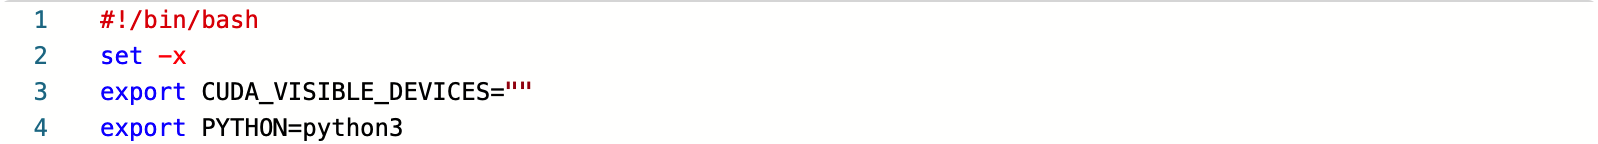

* 不启用：CUDA_VISIBLE_DEVICES=""
* 启用：CUDA_VISIBLE_DEVICES="0"

### 指定路径
start.sh中

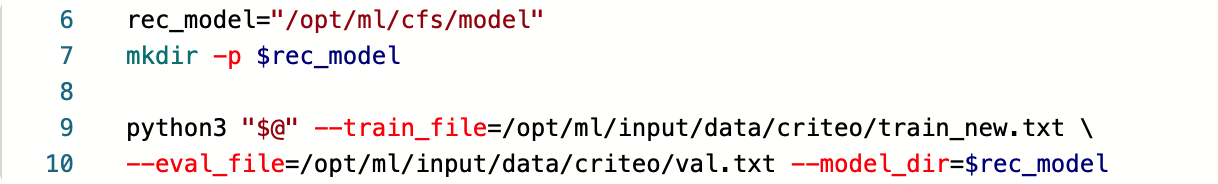

* --train_file：训练数据路径
* --eval_file：测试数据路径
* --model_dir：模型保存路径

### 系统环境变量
TF_CONFIG：

```
{
    "cluster": {
        "ps": [
            "train-590260157068136960-4hfxrl455zi8-ps-0.train-100005348929.svc:2222"
        ],
        "worker": [
            "train-590260157068136960-4hfxrl455zi8-worker-0.train-100005348929.svc:2222"
        ]
    },
    "task": {
        "type": "ps",
        "index": 0
    },
    "environment": "cloud"
}
```
用户可对TF_CONFIG做一些处理，例如：

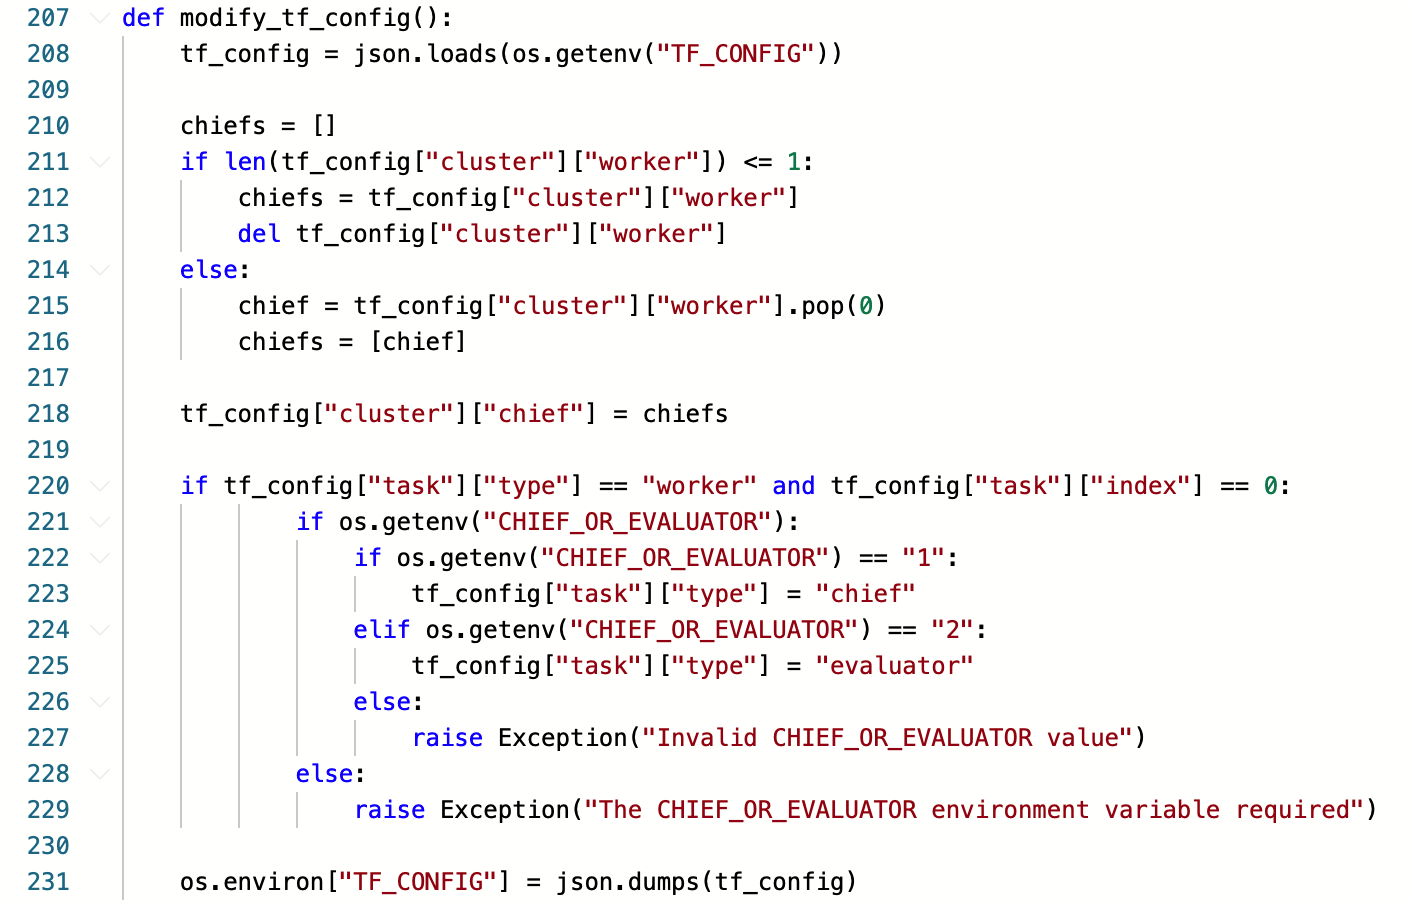

# 使用Tikit提交训练任务

In [1]:
from tikit.client import Client
from tikit import models

# 初始化client。在公有云TI平台的环境（包括notebook和训练任务）中可以不填地区，环境变量中已经有地区信息。
# secret_id获取地址：https://console.cloud.tencent.com/cam/capi。
client = Client("your_secret_id", "your_secret_key", "<region>")

In [ ]:
#上传代码到cos
client.upload_to_cos("./code", "demo-1256580188", "recommend_example/code")

In [4]:
# 查看训练框架
client.describe_training_frameworks()

框架名称,版本,训练模式
TENSORFLOW,ti-acc1.0-tf1.15-py3.6-cuda10.0-gpu,PS_WORKER
TENSORFLOW,tf1.15-py3.7-cpu,"PS_WORKER, MPI, HOROVOD"
TENSORFLOW,tf1.15-py3.7-cuda10.0-gpu,"PS_WORKER, MPI, HOROVOD"
TENSORFLOW,tf2.4-py3.8-cpu,"PS_WORKER, MPI, HOROVOD"
TENSORFLOW,tf2.4-py3.8-cuda11.1-gpu,"PS_WORKER, MPI, HOROVOD"
PYTORCH,ti-acc2.0-torch1.9-py3.8-cuda11.1-gpu,DDP
PYTORCH,torch1.9-py3.8-cuda11.1-gpu,"DDP, MPI, HOROVOD"
SPARK,spark2.4.5-cpu,SPARK
PYSPARK,spark2.4.5-py3.7-cpu,SPARK


In [3]:
# 查询计算资源配置
client.describe_postpaid_training_price()

配置名称,描述,每小时价格（单位：元）
TI.S.MEDIUM.POST,2C4G,0.46
TI.S.LARGE.POST,4C8G,0.9
TI.S.2XLARGE16.POST,8C16G,1.13
TI.S.2XLARGE32.POST,8C32G,1.44
TI.S.4XLARGE32.POST,16C32G,2.22
TI.S.4XLARGE64.POST,16C64G,2.85
TI.S.6XLARGE48.POST,24C48G,5.34
TI.S.6XLARGE96.POST,24C96G,3.97
TI.S.8XLARGE64.POST,32C64G,3.53
TI.S.8XLARGE128.POST,32C128G,5.29


In [18]:
# 提交训练任务
input_datas = [
    models.TrainingDataConfig.new_mount_cfs("cfs-8wk1ejv7", "/", "/opt/ml/input/data/cfs/"), # 这里训练需要使用CFS共享存储保存checkpoint文件
    models.TrainingDataConfig.new_mount_hdfs("emr-jz96589t", "/criteo", "/opt/ml/input/data/criteo/"), # HDFS提供训练数据   
]

framework = models.FrameworkInfo.new_system_framework("TENSORFLOW", "tf1.15-py3.7-cpu", "PS_WORKER")

ps_resource = models.ResourceConfigInfo.new_postpaid("TI.S.2XLARGE16.POST", 1)
worker_resource = models.ResourceConfigInfo.new_postpaid("TI.S.2XLARGE16.POST", 1)

result = client.create_training_task("demo-rec",
                                     framework,
                                     "demo-1256580188/output/", 
                                     worker_resource,
                                     "demo-1256580188/recommend_example/code/",
                                     ps_resource,
                                     input_data_config=input_datas,
                                     ps_start_cmd="sh start_1ps.sh",
                                     worker_start_cmd="sh start_1worker1eval.sh",                     
                                     vpc_id="vpc-0utfm1wr",
                                     sub_net_id="subnet-d4v5hrpy")
print(result)
traind_task_id = result.Id

{"Id": "train-605738224339739520", "RequestId": "a1b7527e-7d79-4d55-b2bf-30850a89d47f"}


# 发布模型

In [ ]:
# 查询支持的推理框架
client.describe_system_reasoning_images()

In [ ]:
# 将训练得到的模型发布到模型仓库
reasoning_env = models.ReasoningEnvironment.new_system_environment("tensorflow1.15-py37(gpu)")
result = client.create_model_by_task("推理案例集-demo",
                            traind_task_id, 
                            reasoning_env,
                            "demo-1256580188/reasoning-models/",
                            "SAVED_MODEL",
                            training_model_cos_path="demo-1256580188/output/train-605711305363776384/model/export/saved_model/1662111628/")
print(result)
model_version_id = result.TrainingModelVersionId
model_id = result.Id
## 输出类似
## {"Id": "m-623753185473072512", "TrainingModelVersionId": "mv-v1-623753185473072513", "RequestId": "c9d22ac3-5b04-43be-854e-f5e5b10d62c9"}

In [ ]:
# 查询模型的目录
client.describe_training_model_version(model_version_id)

# 添加推理脚本
需要将infer目录下的config.json, model_service.py两个文件上传到模型仓库对应的cos中

In [37]:
# 上传model_service.py文件
client.upload_to_cos("infer/model_service.py",
                     "demo-1256580188",
                     f'reasoning-models/{model_id}/{model_version_id}/')

In [38]:
# 上传config.json文件
client.upload_to_cos("infer/config.json",
                     "demo-1256580188",
                     f'reasoning-models/{model_id}/{model_version_id}/')

# 启动模型服务

In [ ]:
# 查看后付费实例列表
client.describe_postpaid_reasoning_price()

In [ ]:
# 以后付费单卡T4机器启动
worker_resource = models.ModelServiceResourceConfigInfo.new_postpaid("TI.GN7.2XLARGE40.POST")
# 设置模型
model = models.ModelConfigInfo.new_model_reference_lite(model_version_id)
# 用发布模型
result = client.create_model_service("推理案例集demo",
                            worker_resource,
                            model_config_info=model)
service_id = result.Service.ServiceId
service_group_id = result.Service.ServiceGroupId
print(f'ServiceID: {service_id}, ServiceGroupID: {service_group_id}')

# 服务调用

In [ ]:
# 查询调用地址
result = client.describe_service_call_info(service_group_id)
addr = result.ServiceCallInfo.OuterHttpAddr
addr

### 使用infer目录下的input.json作为请求内容进行服务调用

模型针对输入样本（包含user、query、以及query所匹配的doc），预测这些doc曝光后获得点击的概率。其中输出结果中，auc是一种评价指标，评价的是模型针对输入batch样本的预测准确性总体指标；后面的predict是512个float字段，代表的是预测的每个样本的点击概率

```bash
# 在终端中使用curl 发起请求
curl -X POST -H 'Content-Type: application/json' <addr>/v1/models/m:predict -d @infer/input.json
# 以下为请求的返回
{"auc": 0.7210801824268158, "prediction": [[0.0], [0.0], [0.01835423707962036], [0.0], [0.0], [0.0], [0.0], [0.9999998807907104], [0.9920336008071899], [0.006983846426010132], [0.0], [7.748603820800781e-07], [0.0], [1.1026859283447266e-06], [0.8884567022323608], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.9999291896820068], [0.0], [8.851289749145508e-06], [0.0], [0.0006372332572937012], [0.0], [0.0], [1.7881393432617188e-07], [7.492303848266602e-05], [0.0], [0.0], [0.0], [1.0], [0.0008492469787597656], [0.0], [0.0], [0.9997251033782959], [9.47713851928711e-05], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.9999985098838806], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [3.260374069213867e-05], [0.0], [1.1920928955078125e-07], [2.980232238769531e-07], [0.0], [0.0], [0.9999996423721313], [0.0], [0.0], [0.0], [0.016189754009246826], [0.0], [0.0], [0.9999836683273315], [0.0], [0.9991923570632935], [0.0], [0.0003603696823120117], [0.0], [0.0], [0.0], [0.0], [3.516674041748047e-06], [0.0], [3.3974647521972656e-06], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.999999463558197], [0.0], [0.0103243887424469], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.9999628067016602], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [2.682209014892578e-07], [0.0], [0.0], [0.0], [4.76837158203125e-07], [0.0], [0.0], [0.0], [1.1920928955078125e-07], [0.0], [0.0], [1.0], [0.0], [0.0], [0.997135579586029], [0.0], [0.0], [0.0001278221607208252], [0.9999908208847046], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.000471264123916626], [0.9999855756759644], [0.0], [0.001816868782043457], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0010852515697479248], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.9974162578582764], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0013593733310699463], [0.0], [5.3942203521728516e-06], [0.0], [0.0], [1.8477439880371094e-06], [0.0], [0.9988768696784973], [0.0], [0.0], [0.0], [1.5079975128173828e-05], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.988812267780304], [0.0], [0.0], [0.0], [0.0], [0.0], [4.172325134277344e-07], [0.0], [0.0], [3.874301910400391e-06], [0.0], [0.0], [0.0], [0.023814022541046143], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.9999929666519165], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [2.9474496841430664e-05], [0.0], [0.0], [0.0009626448154449463], [0.0], [5.304813385009766e-06], [0.0], [0.0], [0.0], [0.0], [0.0003299117088317871], [0.0], [0.0], [0.0], [0.0], [0.9978445768356323], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.998794436454773], [0.0], [0.0], [0.0], [8.940696716308594e-08], [0.0], [0.0], [0.0], [0.0], [1.4394521713256836e-05], [0.9999774694442749], [5.543231964111328e-06], [2.9802322387695312e-08], [0.0], [0.9993705749511719], [0.0], [2.5212764739990234e-05], [0.0], [0.059135496616363525], [0.0], [0.0], [1.0], [0.0], [0.0009387731552124023], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0006690025329589844], [0.9995121955871582], [0.0], [0.9972196817398071], [0.9240990877151489], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [2.9802322387695312e-08], [0.0], [1.0371208190917969e-05], [0.0], [0.0], [0.0], [0.0], [0.0], [0.9051128625869751], [0.0], [1.0], [0.0007086098194122314], [0.0], [0.0], [1.0], [0.0], [0.0], [0.11084356904029846], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.9998174905776978], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.9688045978546143], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.997391939163208], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.41617366671562195], [0.0], [0.0], [0.0], [0.0], [0.0], [0.5162906050682068], [8.165836334228516e-06], [1.0], [0.74773108959198], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.00017747282981872559], [0.0], [0.0], [0.9992722868919373], [0.0], [0.00019609928131103516], [1.1920928955078125e-06], [1.0], [0.0], [0.9999983310699463], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.7826001644134521], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [9.179115295410156e-06], [0.0], [0.9999889731407166], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.9999973773956299], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.1920928955078125e-07], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [8.940696716308594e-08], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.2516975402832031e-06], [0.0], [0.00015044212341308594], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]}
```